In [1]:
!pip install patchify

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.layers import Layer, Input
from keras.layers import Input, Conv2D, Dense, MaxPooling2D, BatchNormalization, Flatten, Dropout, Conv2DTranspose, concatenate, Lambda
from keras.preprocessing.image import img_to_array, load_img
from keras.models import Model, Sequential
from keras.layers import Concatenate, UpSampling2D
from tensorflow.keras.utils import to_categorical
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import random

# Load Images


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
path = "/content/drive/MyDrive/Deep Learning/Semantic segmentation dataset"

In [5]:
minmaxscaler = MinMaxScaler()
image_patch_size = 256

In [6]:
# Initialize lists to store image and mask data
image_dataset = []
mask_dataset = []

# Iterate through 'images' and 'masks' folders
for image_type in ['images' , 'masks']:
  # Set image extension based on the image type
  if image_type == 'images':
    image_extension = 'jpg'
  elif image_type == 'masks':
     image_extension = 'png'
  # Iterate through tile IDs and image IDs
  for tile_id in range(1,8):
    for image_id in range(1,20):
      # Load image from file path
      image = cv2.imread(f'{path}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
      # Check if image is not None (i.e., successfully loaded)
      if image is not None:
         # Convert mask images from BGR to RGB
        if image_type == 'masks':
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Crop image to match patch size
        #print(image.shape)
        size_x = (image.shape[1]//image_patch_size)*image_patch_size
        size_y = (image.shape[0]//image_patch_size)*image_patch_size
        #print("{} --- {} - {}".format(image.shape, size_x, size_y))
        image = Image.fromarray(image)
        image = image.crop((0,0, size_x, size_y))
        #print("({},  {})".format(image.size[0],image.size[1]))
        image = np.array(image)
         # Patch the image into smaller segments
        patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
        #print(len(patched_images))
        # Iterate through patches
        for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):
            # For 'images', apply Min-Max scaling and store in image_dataset
            if image_type == 'images':
              individual_patched_image = patched_images[i,j,:,:]
              #print(individual_patched_image.shape)
              individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
              individual_patched_image = individual_patched_image[0]
              #print(individual_patched_image.shape)
              image_dataset.append(individual_patched_image)
            # For 'masks', store in mask_dataset
            elif image_type == 'masks':
              individual_patched_mask = patched_images[i,j,:,:]
              individual_patched_mask = individual_patched_mask[0]
              mask_dataset.append(individual_patched_mask)


In [7]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [8]:
print(len(image_dataset))
print(len(mask_dataset))

945
945


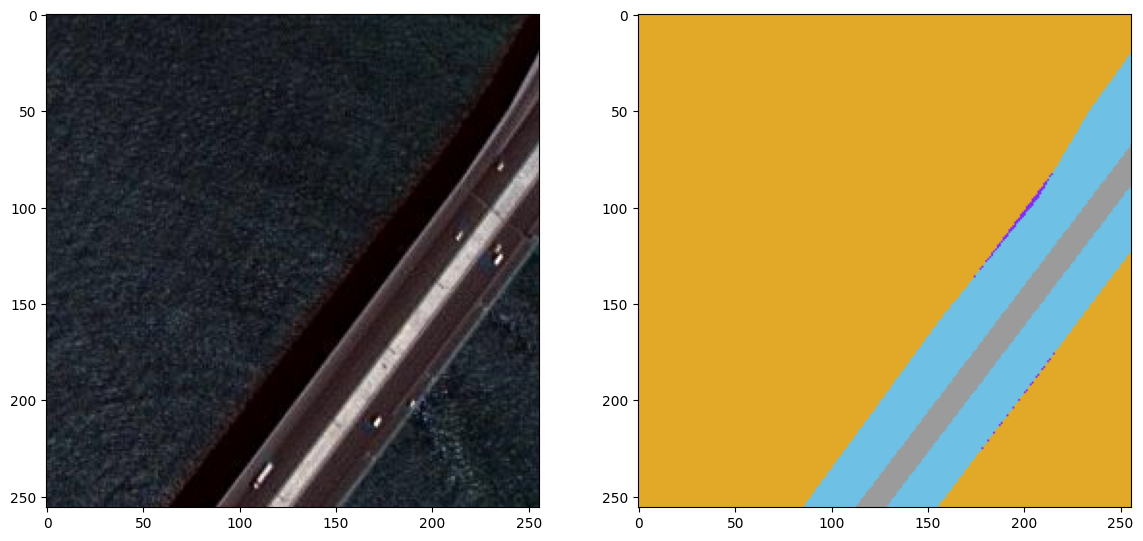

In [9]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])

In [10]:
# Define color codes for different classes (for label encoding)
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)
# Repeat the above process for other classes (e.g., land, road, vegetation, water, unlabeled)
class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [11]:
label = individual_patched_mask

In [12]:
# Define function for label encoding
def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  label_segment[np.all(label == class_water, axis=-1)] = 0
  label_segment[np.all(label == class_land, axis=-1)] = 1
  label_segment[np.all(label == class_road, axis=-1)] = 2
  label_segment[np.all(label == class_building, axis=-1)] = 3
  label_segment[np.all(label == class_vegetation, axis=-1)] = 4
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
  #print(label_segment)
  label_segment = label_segment[:,:,0]
  #print(label_segment)
  return label_segment

In [13]:
# Iterate through mask_dataset to perform label encoding
labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)

In [14]:
# Convert labels to numpy array
labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

In [15]:
print("Total unique labels based on masks: ",format(np.unique(labels)))

Total unique labels based on masks:  [0 1 2 3 4 5]


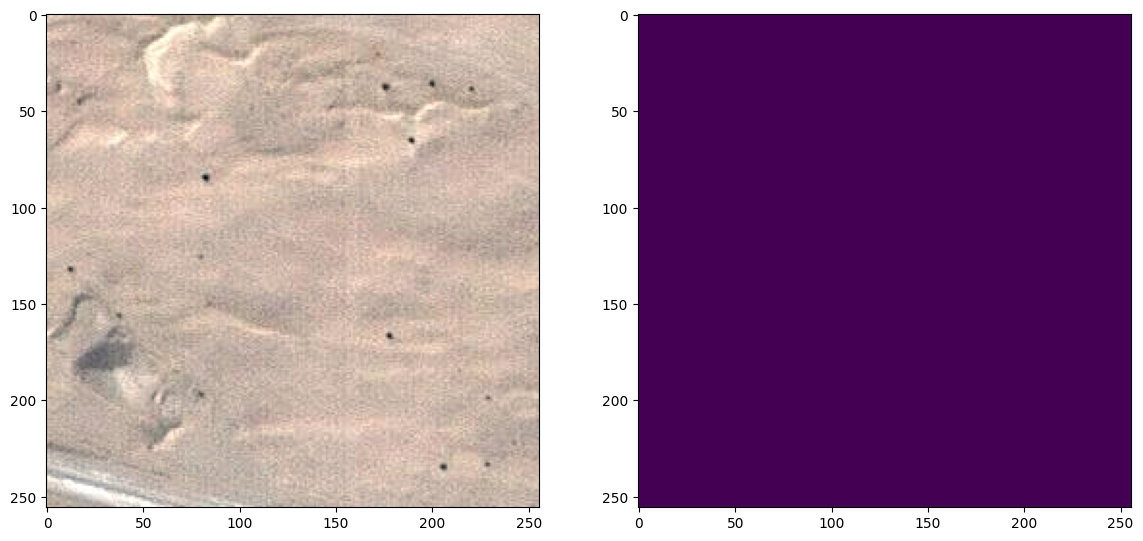

In [16]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
#plt.imshow(mask_dataset[random_image_id])
plt.imshow(labels[random_image_id][:,:,0])

In [17]:
total_classes = len(np.unique(labels))
total_classes

6

In [18]:
# Perform one-hot encoding
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)

In [19]:
master_trianing_dataset = image_dataset

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(master_trianing_dataset, labels_categorical_dataset, test_size=0.15, random_state=100)

In [21]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(803, 256, 256, 3)
(142, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 6)


In [22]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

In [23]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


In [24]:
from keras import backend as K

def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value


In [25]:
def multi_unet_model(n_classes=5, image_height=256, image_width=256, image_channels=1):

  inputs = Input((image_height, image_width, image_channels))

  source_input = inputs

  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.2)(c1)
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model

In [26]:
metrics = ["accuracy", jaccard_coef]

In [27]:
def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes,
                          image_height=image_height,
                          image_width=image_width,
                          image_channels=image_channels)

In [28]:
model = get_deep_learning_model()

In [29]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]

In [30]:
!pip install -U segmentation-models

In [31]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [32]:
dice_loss = sm.losses.DiceLoss(class_weights = weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [33]:
tf.keras.backend.clear_session()


In [34]:
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)

In [35]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [36]:
model_history = model.fit(X_train, y_train,
                          batch_size=16,
                          verbose=1,
                          epochs=10,
                          validation_data=(X_test, y_test),
                          shuffle=False)

Epoch 1/10
51/51 [==============================] - 52s 410ms/step - loss: 1.0039 - accuracy: 0.5333 - jaccard_coef: 0.2519 - val_loss: 0.9923 - val_accuracy: 0.6459 - val_jaccard_coef: 0.2930
Epoch 2/10
51/51 [==============================] - 11s 218ms/step - loss: 0.9883 - accuracy: 0.6703 - jaccard_coef: 0.3377 - val_loss: 0.9724 - val_accuracy: 0.6720 - val_jaccard_coef: 0.3899
Epoch 3/10
51/51 [==============================] - 11s 219ms/step - loss: 0.9661 - accuracy: 0.6984 - jaccard_coef: 0.4448 - val_loss: 0.9708 - val_accuracy: 0.6677 - val_jaccard_coef: 0.4335
Epoch 4/10
51/51 [==============================] - 12s 240ms/step - loss: 0.9573 - accuracy: 0.7304 - jaccard_coef: 0.4864 - val_loss: 0.9669 - val_accuracy: 0.6969 - val_jaccard_coef: 0.4682
Epoch 5/10
51/51 [==============================] - 11s 217ms/step - loss: 0.9515 - accuracy: 0.7438 - jaccard_coef: 0.5108 - val_loss: 0.9854 - val_accuracy: 0.6411 - val_jaccard_coef: 0.4138
Epoch 6/10
51/51 [=================

In [37]:
history_a = model_history
history_a.history

{'loss': [1.0038872957229614,
  0.9883403182029724,
  0.9660770893096924,
  0.9573218822479248,
  0.9514927268028259,
  0.9495722651481628,
  0.9453381896018982,
  0.9400160312652588,
  0.9352032542228699,
  0.9319033622741699],
 'accuracy': [0.5332596898078918,
  0.6703181862831116,
  0.6983708143234253,
  0.7303707003593445,
  0.7437950968742371,
  0.7507053017616272,
  0.7619574069976807,
  0.7790448069572449,
  0.7945623397827148,
  0.8041812777519226],
 'jaccard_coef': [0.2518807351589203,
  0.33766525983810425,
  0.4448428750038147,
  0.4864156246185303,
  0.5107606053352356,
  0.52010178565979,
  0.5358460545539856,
  0.5646736025810242,
  0.5906246900558472,
  0.6059074401855469],
 'val_loss': [0.9922569394111633,
  0.9724162817001343,
  0.9707756638526917,
  0.9668514728546143,
  0.9854003190994263,
  0.9786734580993652,
  0.9656471014022827,
  0.9614267349243164,
  0.9603802561759949,
  0.9609556794166565],
 'val_accuracy': [0.6458971500396729,
  0.6720002889633179,
  0.66766

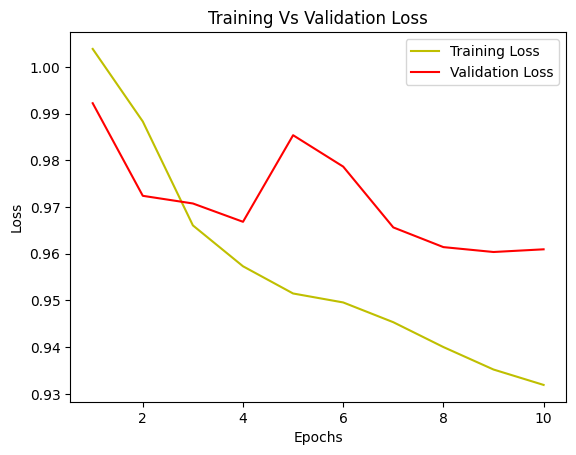

In [38]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

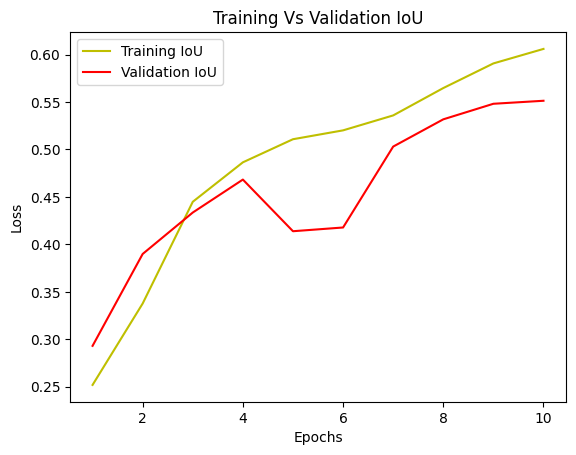

In [39]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()



In [40]:
y_pred = model.predict(X_test)

5/5 [==============================] - 5s 57ms/step


In [41]:
y_pred_argmax = np.argmax(y_pred, axis=3)
y_test_argmax = np.argmax(y_test, axis=3)

In [52]:
test_image_number = random.randint(0, len(X_test))

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

1/1 [==============================] - 0s 27ms/step


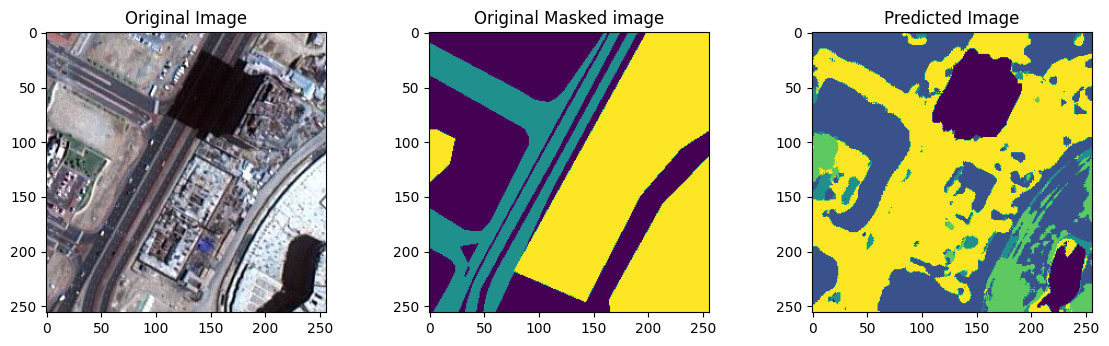

In [53]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)
plt.subplot(232)
plt.title("Original Masked image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(predicted_image)


In [44]:
# model.save("model.h5")

In [45]:
!ls -lah

total 20K
drwxr-xr-x 1 root root 4.0K May 11 14:57 .
drwxr-xr-x 1 root root 4.0K May 11 14:47 ..
drwxr-xr-x 4 root root 4.0K May  9 13:24 .config
drwx------ 5 root root 4.0K May 11 14:57 drive
drwxr-xr-x 1 root root 4.0K May  9 13:24 sample_data
